# 1. 自注意力

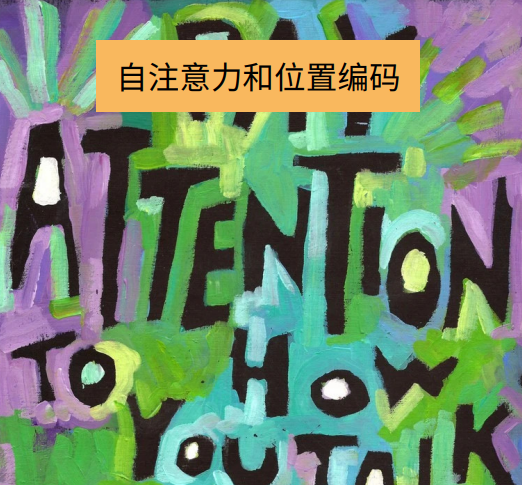

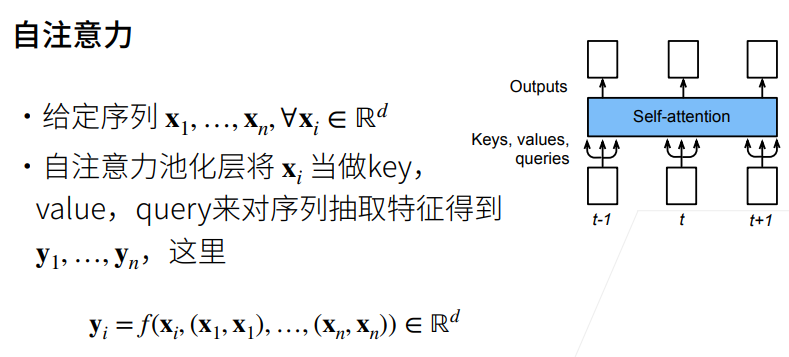

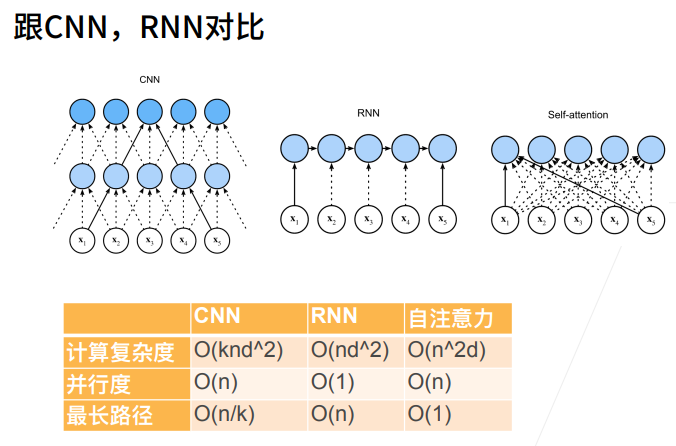

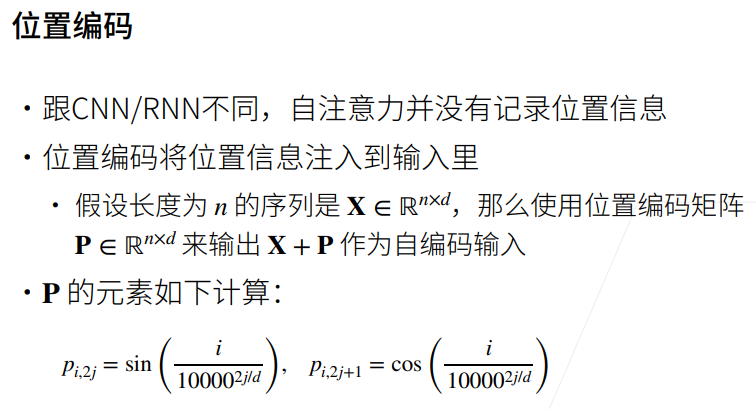

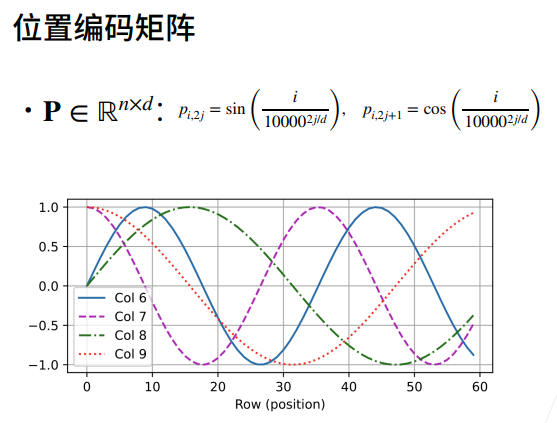

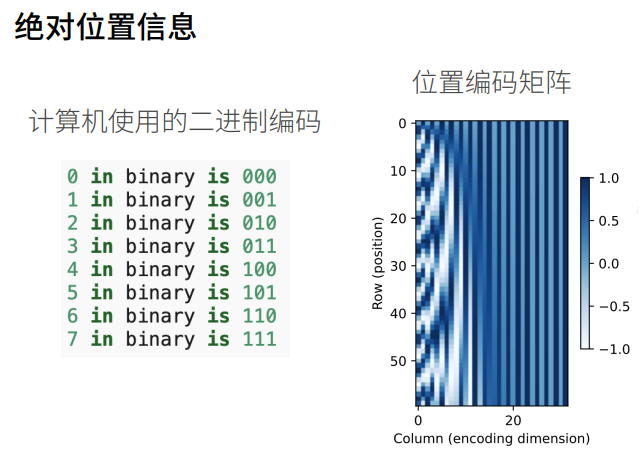

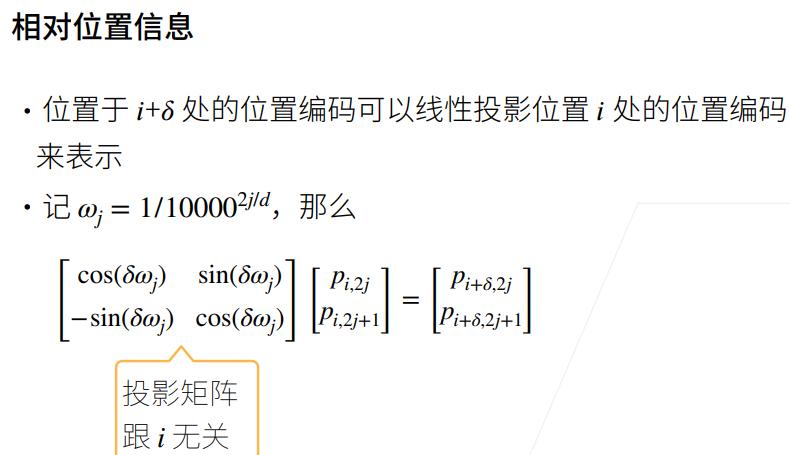

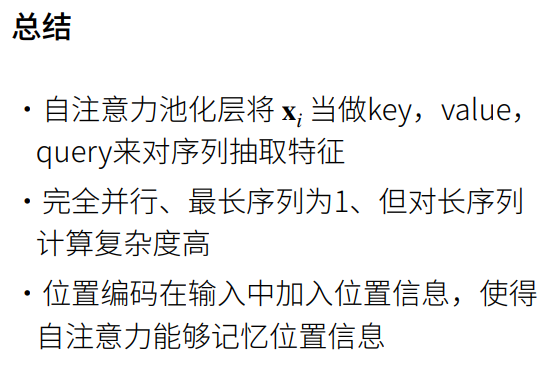

# 2. 自注意力

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# 设置隐藏单元数量和头的数量
num_hiddens, num_heads = 100, 5
# 创建多头注意力实例
# 输入参数为隐藏单元数量、查询维度、键维度、值维度、头的数量和dropout率
attention = d2l.MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                                  num_hiddens, num_heads, 0.5)
# 将多头注意力设置为评估模式，不进行训练
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [3]:
# 设置批量大小、查询数和有效长度
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
# 创建形状为(batch_size, num_queries, num_hiddens)的输入张量X，初始化为全1
X = torch.ones((batch_size, num_queries, num_hiddens))
# 对输入张量X应用多头注意力机制，并获取输出的形状
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

In [4]:
# 位置编码
class PositionalEncoding(nn.Module):
    # 初始化函数，接收隐藏单元数量、dropout率和最大序列长度作为输入
    def __init__(self, num_hiddens, dropout, max_len=1000):
        # 调用父类的初始化函数
        super(PositionalEncoding, self).__init__()
        # 创建一个dropout层，用于随机丢弃输入的元素
        self.dropout = nn.Dropout(dropout)
        # 创建一个形状为(1, max_len, num_hiddens)的位置编码张量P，初始化为全0
        self.P = torch.zeros((1, max_len, num_hiddens))
        # 生成位置编码矩阵X，其中每一行表示一个位置的编码，编码方式采用sin和cos函数
        # 编码公式：X[i, j] = sin(i / 10000^(2j / num_hiddens)) 或 cos(i / 10000^(2j / num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, 
                               torch.arange(0, num_hiddens, 2, dtype=torch.float32) /
                               num_hiddens)
        # 将位置编码矩阵中的偶数维度的元素替换为sin函数的结果
        self.P[:,:,0::2] = torch.sin(X)
        # 将位置编码矩阵中的奇数维度的元素替换为cos函数的结果
        self.P[:,:,1::2] = torch.cos(X)
        
    # 前向传播函数，接收输入张量X作为输入
    def forward(self, X):
        # 将位置编码张量P与输入张量X相加，并将结果移动到与X相同的设备上
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        # 对相加后的结果应用dropout，并返回结果
        return self.dropout(X)

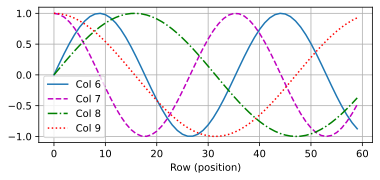

In [5]:
# 行代表标记在序列中的位置，列代表位置编码的不同维度
# 设置位置编码的维度和序列的长度
encoding_dim, num_steps = 32, 60
# 创建位置编码器实例，传入位置编码的维度和dropout率
pos_encoding = PositionalEncoding(encoding_dim, 0)
# 将位置编码器设置为评估模式，不进行训练
pos_encoding.eval()
# 应用位置编码器到全0张量上，得到位置编码后的张量X
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
# 获取位置编码器中的位置编码张量P，截取与X相同长度的部分
P = pos_encoding.P[:, :X.shape[1], :]
# 绘制位置编码张量P中特定维度的子集
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
        figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])    

In [6]:
# 循环遍历范围为0到7的数字
for i in range(8):
    # 打印当前数字的二进制表示，使用字符串格式化进行对齐和补零
    print(f'{i} in binary is {i:>03b}')

0 in binary is 000
1 in binary is 001
2 in binary is 010
3 in binary is 011
4 in binary is 100
5 in binary is 101
6 in binary is 110
7 in binary is 111


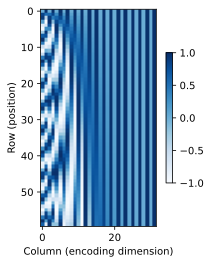

In [7]:
# 在编码维度上降低频率
# 从位置编码张量P中获取第一个样本的编码部分，并添加两个维度
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
# 显示热力图，以编码维度为x轴，位置为y轴
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                 ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')